In [2]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from shapely import wkt

In [9]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

font = {
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


### Lets see the route maps on a 2D longitude latitude plane

* Plotting only the data from last month
* The color axis shows the mean delay

In [3]:
url_list  = pd.read_csv('https://data.winnipeg.ca/resource/cymk-nyei.csv', usecols=['url', 'end_date'], parse_dates=['end_date'])
url_list = url_list[url_list['end_date'] > '2023-09-30'].reset_index(drop=True)

In [4]:
mean_dev_dict = {}
for idx, row in url_list.iterrows():
    # iterrows is memory efficient
    delayed_df = delayed(pd.read_csv)(row['url'])
    
    df_deviation = delayed_df[['Stop Number', 'Deviation', 'Location']].compute()
    df_deviation["Location"] = gpd.GeoSeries.from_wkt(df_deviation["Location"])
    df_deviation = gpd.GeoDataFrame(df_deviation, geometry="Location")
    mean_dev_dict[str(row['end_date'])] = df_deviation.groupby(['Stop Number', 'Location']).mean().reset_index()
    # print(idx, row['end_date'])
    if idx > 2:
        break

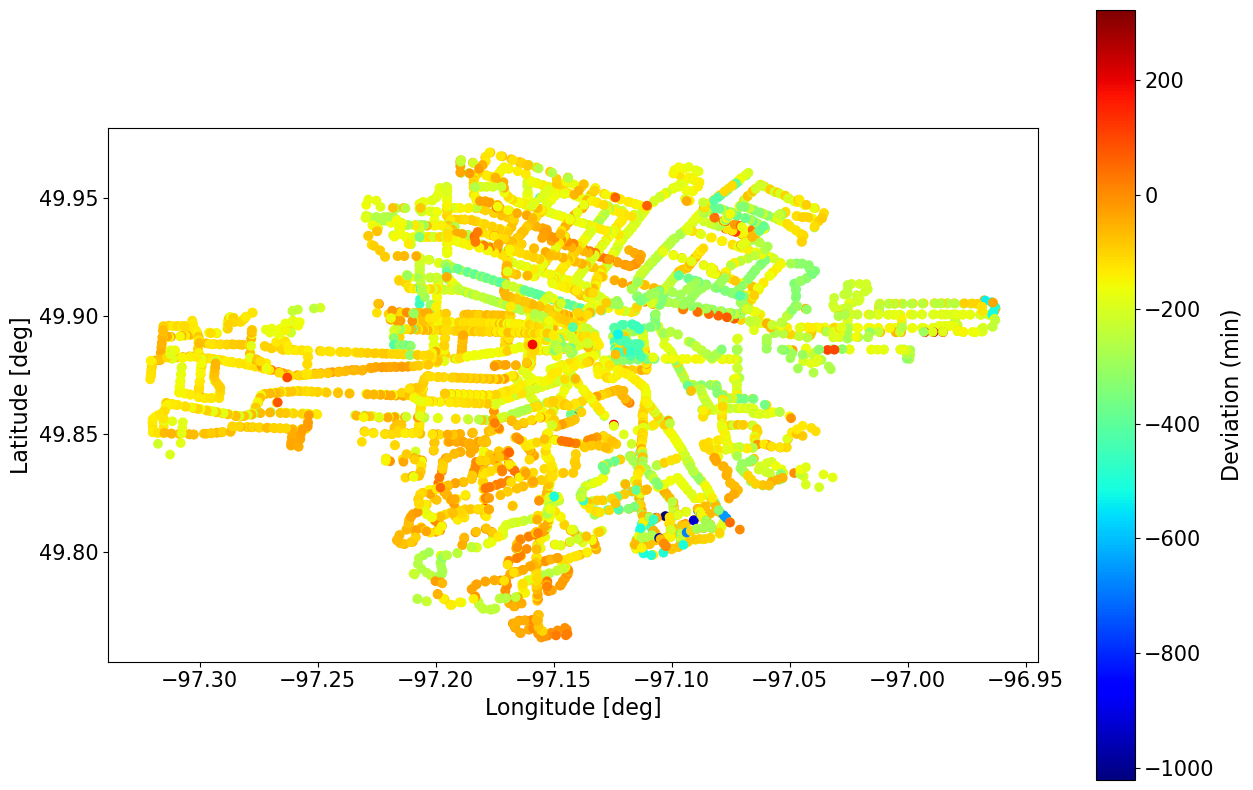

In [11]:
tmp_df = mean_dev_dict["2023-10-31 00:00:00"]
df_deviation = gpd.GeoDataFrame(tmp_df, geometry="Location")
ax = df_deviation.plot(column='Deviation', cmap="jet", figsize=(15, 10), legend=True, legend_kwds={'label': "Deviation (min)"})
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
plt.savefig("deviation_map.pdf", dpi=300, bbox_inches='tight')